# <span style="color: blue;">ให้กรอกรหัสนิสิต และชื่อ-นามสกุลของสมาชิกในทีม</span>
# <span style="color: blue;">(ห้ามมีสมาชิกเกิน 2 คน)</span>
## รหัสนิสิต ชื่อ-นามสกุล

<span style="color: green;">6714450249 นายหรินทร์ ธนะนาม</span>

## Image Classification: Comparing No Augmentation, Data Augmentation, and Pretrained Models

This exercise investigates image classification on the CIFAR-100 dataset by comparing three different training strategies: a baseline model trained without any augmentation, a model trained with data augmentation techniques to improve generalization, and a model leveraging transfer learning with pretrained weights. The goal is to evaluate how each approach affects classification performance, focusing on accuracy, loss behavior, and robustness.

In [52]:
import os

# must come *before* any Tensorflow import
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [53]:
from __future__ import print_function
import keras
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
import numpy as np
import os, random, tensorflow as tf
import requests, pickle

def set_seed(seed_value=12345):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)


## Testing ImageDataGenerator

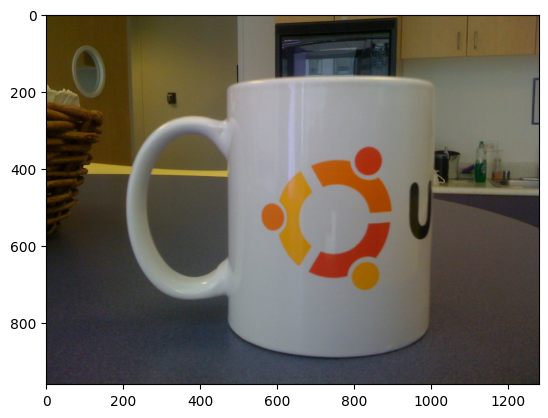

In [55]:
import gdown, requests
from PIL import Image
import numpy as np

gdown.download("https://drive.google.com/uc?export=download&id=1xUwP3DVt690D2NpgDdoNaNE37uoa0a3V",
               "coffee_mug.jpg", quiet=True)
image = Image.open("coffee_mug.jpg")
image = np.expand_dims(image, axis=0).astype('float32')/255
plt.imshow(image[0])

In [56]:
datagen = ImageDataGenerator(
    rotation_range=0,       # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0,    # randomly shift images horizontally (fraction of total width)
    height_shift_range=0,   # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)    # randomly flip images

image_generator = datagen.flow(image)

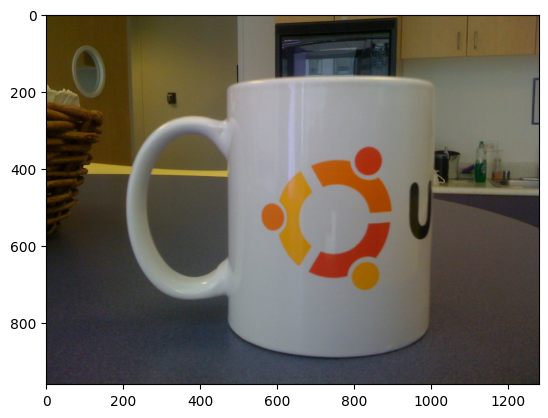

In [57]:
plt.imshow(next(image_generator)[0])

## Loading Dataset

In [58]:
url = "https://drive.google.com/uc?id=1KiNBzO6Rglrs96Ar92sVjYckAvm2A0Fi"
(_X, _y) = pickle.loads(requests.get(url).content)

class_names = ['bottle', 'bowl', 'can', 'cup', 'plate']

## <span style="color:orange"> เกณฑ์การให้คะแนน (คะแนนเต็ม 100 คะแนน)</span>
* ### <span style="color:darkcyan"> หากสามารถทำตามข้อกำหนดได้ครบและสมบูรณ์ทุกข้อ พร้อมอธิบายและเปรียบเทียบประสิทธิภาพของโมเดลทั้งหมดได้อย่างชัดเจน ได้รับคะแนนเต็ม 100 คะแนน</span>
* ### <span style="color:darkcyan"> หากมีข้อบกพร่องน้อยหรืออธิบายได้ดีพอประมาณ จะได้รับ 70 คะแนน</span>
* ### <span style="color:darkcyan"> หากมีข้อบกพร่องหรือโค้ดทำงานไม่ถูกต้อง จะได้รับ 40 คะแนน</span>
* ### <span style="color:darkcyan"> หากมีข้อบกพร่องอย่างมาก โค้ดรันไม่ได้ หรือไม่ได้เขียนโค้ดส่งมา จะได้รับศูนย์คะแนน</span>
* ### <span style="color:darkcyan"> หากโจทย์ไม่ได้กำหนดให้ทำ </span><span style="color:red">ห้ามใช้ Early Stopping, ห้ามใช้ Best Weights, ห้ามใช้ Data Augmentation และห้ามใช้โมเดล Pretrained ในการเทรนโมเดล</span>

## <span style="color:green"> 1. จากชุดข้อมูลที่เตรียมไว้ให้ซึ่งอยู่ในตัวแปร _X และ _y ให้แบ่งข้อมูลออกเป็นชุดข้อมูล train, val, และ test ด้วยอัตราส่วน 80:5:15 และให้ทุกชุดข้อมูลมีจำนวนข้อมูลของแต่ละคลาสเท่ากัน หลังจากที่แบ่งชุดข้อมูลเสร็จ ให้แสดงจำนวนข้อมูลของแต่ละคลาสในทุกชุดข้อมูล</span>

In [59]:
seed_value = 12345

In [60]:
from sklearn.model_selection import train_test_split

# Split data to Train 80% and Test 20% and every class have same number of samples
X_train, X_val_full, y_train, y_val_full = train_test_split(_X, _y, test_size=0.2, random_state=seed_value, stratify=_y)

# Split data to Val 5% and Test 15%
X_val, X_test, y_val, y_test = train_test_split(X_val_full, y_val_full, test_size=0.75, random_state=seed_value, stratify=y_val_full)

In [61]:
def display_class_distribution(y, dataset_name):
    print(f"total {dataset_name} samples: {y.shape[0]}", )
    unique, counts = np.unique(y, return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"{class_names[cls]} samples: {count}")

In [62]:
display_class_distribution(y_train, "Training Set")

total Training Set samples: 2400
bottle samples: 480
bowl samples: 480
can samples: 480
cup samples: 480
plate samples: 480


In [63]:
display_class_distribution(y_val, "Validation Set")

total Validation Set samples: 150
bottle samples: 30
bowl samples: 30
can samples: 30
cup samples: 30
plate samples: 30


In [64]:
display_class_distribution(y_test, "Test Set")

total Test Set samples: 450
bottle samples: 90
bowl samples: 90
can samples: 90
cup samples: 90
plate samples: 90


## <span style="color:green"> 2. ในแต่ละชุดข้อมูล ให้แสดงภาพพร้อมชื่อคลาสออกมาเป็นจำนวน 12 ภาพ</span>

In [65]:
# Must display 36 images, because we've 3 dataset and 12 images per dataset
def display_images(X, y, class_names):
    plt.figure(figsize=(10,10))
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i], cmap=plt.cm.binary)
        plt.title(class_names[np.argmax(y[i])])
    plt.show()

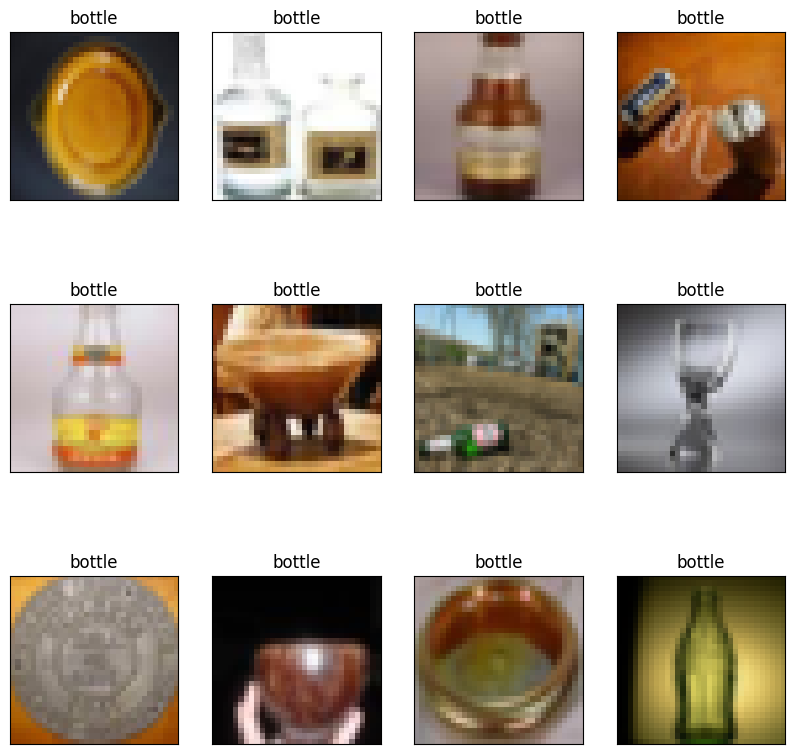

In [66]:
display_images(X_train, y_train, class_names)

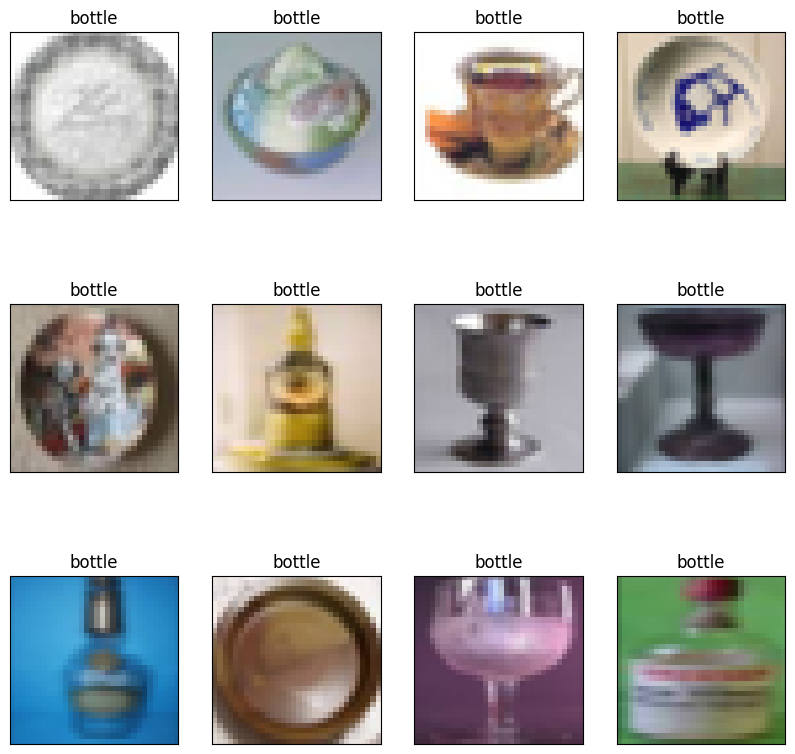

In [67]:
display_images(X_val, y_val, class_names)

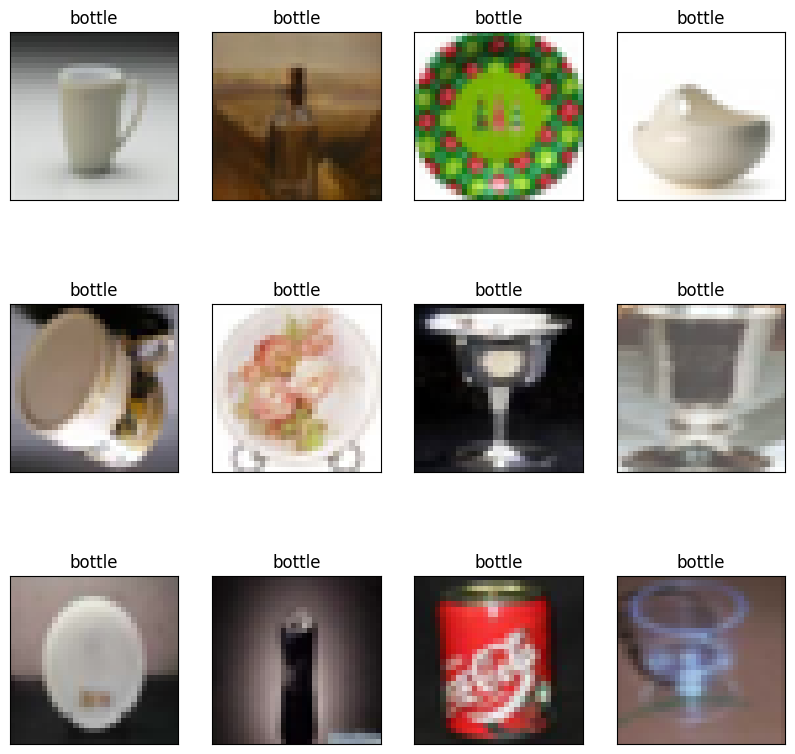

In [68]:
display_images(X_test, y_test, class_names)

### Normalize and One-Hot Encode Datasets โดยปรับโค้ดข้างล่างให้ตรงกับตัวแปรที่ใช้

In [69]:
# Number of classes
n_classes = len(class_names)

# Normalize data: transform pixel into float32
X_train_norm = X_train.astype('float32') / 255
X_val_norm = X_val.astype('float32') / 255
X_test_norm = X_test.astype('float32') / 255

# One-hot encode Labels
y_train_encode = keras.utils.to_categorical(y_train, n_classes)
y_val_encode = keras.utils.to_categorical(y_val, n_classes)
y_test_encode = keras.utils.to_categorical(y_test, n_classes)

## <span style="color:green"> 3. ให้สร้าง เทรน และประเมินผลโมเดล CNN โดยให้ตั้งชื่อตัวแปรโมเดลว่า model_1 ซึ่งในการเทรนโมเดลนี้ห้ามใช้ Data Augmentation</span>

In [82]:
# Create the model_1
model_1_layer = [
    Conv2D(32, (5, 5), strides=(1, 1), padding='same', input_shape=X_train.shape[1:], activation='relu', name='conv_1'),
    Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_2'),
    Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_3'),
    MaxPooling2D(pool_size=(2, 2), name='pool_1'),
    Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_4'),
    Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_5'),
    MaxPooling2D(pool_size=(2, 2), name='pool_2'),
    Flatten(name='flatten_1'),
    Dense(128, activation='softmax', name='dense_1'),
    Dense(n_classes, activation='softmax', name='dense_2')
]
model_1 = Sequential(model_1_layer)
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 conv_2 (Conv2D)             (None, 32, 32, 32)        25632     
                                                                 
 conv_3 (Conv2D)             (None, 32, 32, 64)        51264     
                                                                 
 pool_1 (MaxPooling2D)       (None, 16, 16, 64)        0         
                                                                 
 conv_4 (Conv2D)             (None, 16, 16, 32)        51232     
                                                                 
 conv_5 (Conv2D)             (None, 16, 16, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 8, 8, 64)         

In [83]:
# Compile and train the model_1
from tensorflow.keras.optimizers import Adam
set_seed(12345)

model_1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_1_model_1 = model_1.fit(
    X_train_norm,
    y_train_encode,
    validation_data=(X_val_norm, y_val_encode),
    epochs=50,
    batch_size=32
)

Epoch 1/50
75/75 [==============================] - 2s 13ms/step - loss: 1.6082 - accuracy: 0.2358 - val_loss: 1.6006 - val_accuracy: 0.2667
Epoch 2/50
75/75 [==============================] - 1s 10ms/step - loss: 1.5675 - accuracy: 0.3258 - val_loss: 1.5457 - val_accuracy: 0.3533
Epoch 3/50
75/75 [==============================] - 1s 10ms/step - loss: 1.5431 - accuracy: 0.3746 - val_loss: 1.5365 - val_accuracy: 0.3533
Epoch 4/50
75/75 [==============================] - 1s 10ms/step - loss: 1.5244 - accuracy: 0.4271 - val_loss: 1.5245 - val_accuracy: 0.4133
Epoch 5/50
75/75 [==============================] - 1s 10ms/step - loss: 1.5145 - accuracy: 0.4600 - val_loss: 1.5087 - val_accuracy: 0.4267
Epoch 6/50
75/75 [==============================] - 1s 10ms/step - loss: 1.5065 - accuracy: 0.4663 - val_loss: 1.5033 - val_accuracy: 0.4533
Epoch 7/50
75/75 [==============================] - 1s 10ms/step - loss: 1.4996 - accuracy: 0.4808 - val_loss: 1.4971 - val_accuracy: 0.5333
Epoch 8/50
75

In [84]:
# Evaluate model_1
loss_model_1, acc_model_1 = model_1.evaluate(X_test_norm, y_test_encode)
print("Model 1 Evaluation")
print(f"model_1 accuracy: {acc_model_1:.4f}")
print(f"model_1 loss: {loss_model_1:.4f}")

15/15 [==============================] - 0s 20ms/step - loss: 1.2712 - accuracy: 0.6200
Model 1 Evaluation
model_1 accuracy: 0.6200
model_1 loss: 1.2712


In [77]:
def plot_history(history, title):
    fig, ax = plt.subplots()
    ax.plot(history.history["loss"],'r', marker='.', label="Train")
    ax.plot(history.history["val_loss"],'b', marker='.', label="Validation")
    ax.legend()
    plt.title(f"Loss ({title})")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(history.history["accuracy"],'r', marker='.', label="Train")
    ax.plot(history.history["val_accuracy"],'b', marker='.', label="Validation")
    ax.legend()
    plt.title(f"Accuracy ({title})")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

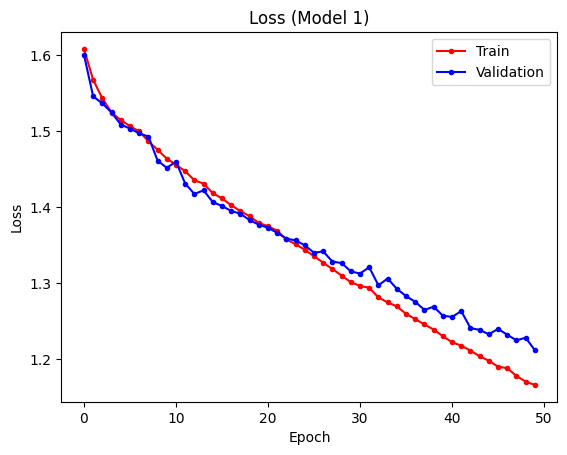

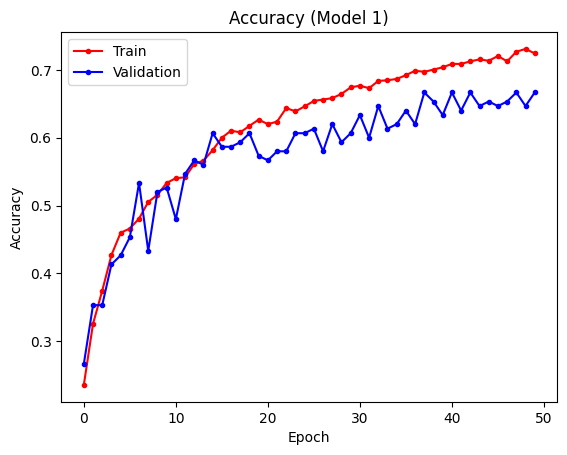

In [85]:
plot_history(history_1_model_1, "Model 1")

## <span style="color:green"> 4. (20 คะแนน) ให้นำโครงสร้างโมเดล model_1 มาสร้างโมเดลที่มีชื่อตัวแปรโมเดลว่า model_2 โดยห้ามปรับเปลี่ยนโครงสร้างโมเดล แต่ให้เทรนโมเดลโดยใช้ Data Augmentation และใช้จำนวน epoch เท่ากับโมเดลก่อนหน้า แล้วจึงประเมินผลโมเดล</span>

In [86]:
# Create model_2 by cloning model_1
from keras.models import clone_model
model_2 = clone_model(model_1)
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 conv_2 (Conv2D)             (None, 32, 32, 32)        25632     
                                                                 
 conv_3 (Conv2D)             (None, 32, 32, 64)        51264     
                                                                 
 pool_1 (MaxPooling2D)       (None, 16, 16, 64)        0         
                                                                 
 conv_4 (Conv2D)             (None, 16, 16, 32)        51232     
                                                                 
 conv_5 (Conv2D)             (None, 16, 16, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 8, 8, 64)         

In [105]:
# Begin data augmentation
data_gen_model_2 = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.25,
    horizontal_flip=True,
    vertical_flip=False
)

image_gen_model_2 = data_gen_model_2.flow(X_train_norm, y_train_encode, batch_size=32)

In [106]:
set_seed(12345)

model_2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_1_model_2 = model_2.fit(
    image_gen_model_2,
    validation_data=(X_val_norm, y_val_encode),
    epochs=50,
    batch_size=32
)

Epoch 1/50
75/75 [==============================] - 3s 31ms/step - loss: 1.0279 - accuracy: 0.6071 - val_loss: 0.9520 - val_accuracy: 0.6200
Epoch 2/50
75/75 [==============================] - 2s 24ms/step - loss: 0.9976 - accuracy: 0.6279 - val_loss: 0.9578 - val_accuracy: 0.6533
Epoch 3/50
75/75 [==============================] - 2s 24ms/step - loss: 0.9971 - accuracy: 0.6275 - val_loss: 0.9615 - val_accuracy: 0.6400
Epoch 4/50
75/75 [==============================] - 2s 24ms/step - loss: 1.0023 - accuracy: 0.6250 - val_loss: 0.9170 - val_accuracy: 0.6733
Epoch 5/50
75/75 [==============================] - 2s 24ms/step - loss: 1.0111 - accuracy: 0.6162 - val_loss: 0.9270 - val_accuracy: 0.6667
Epoch 6/50
75/75 [==============================] - 2s 25ms/step - loss: 1.0047 - accuracy: 0.6300 - val_loss: 0.9102 - val_accuracy: 0.6600
Epoch 7/50
75/75 [==============================] - 2s 26ms/step - loss: 1.0084 - accuracy: 0.6217 - val_loss: 0.9396 - val_accuracy: 0.6533
Epoch 8/50
75

In [107]:
loss_model_2, acc_model_2 = model_2.evaluate(X_test_norm, y_test_encode)
print("Model 2 Evaluation")
print(f"model_2 accuracy: {acc_model_2:.4f}")
print(f"model_2 loss: {loss_model_2:.4f}")

15/15 [==============================] - 0s 21ms/step - loss: 0.9239 - accuracy: 0.6644
Model 2 Evaluation
model_2 accuracy: 0.6644
model_2 loss: 0.9239


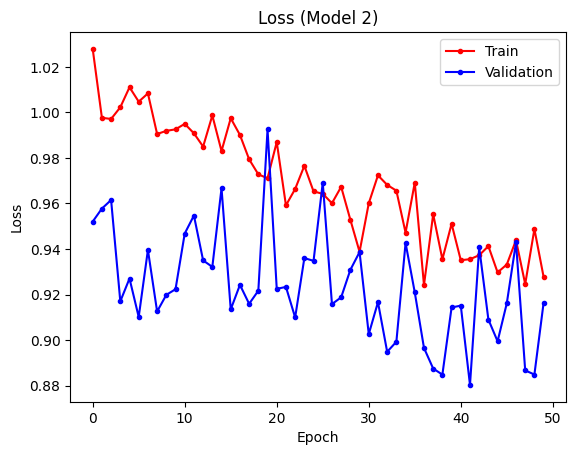

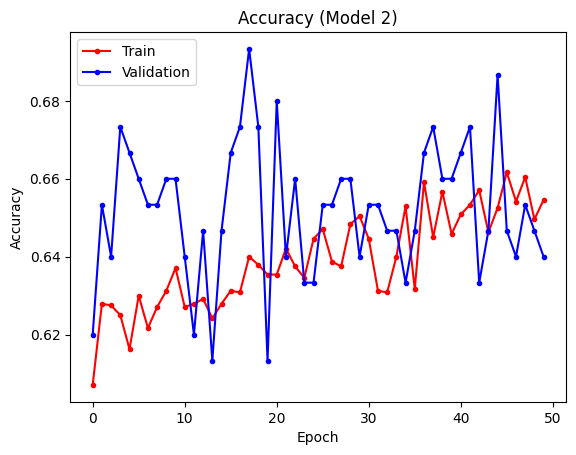

In [108]:
plot_history(history_1_model_2, "Model 2")

## <span style="color:green"> 5. ให้เรียกใช้ฟังก์ชันเพื่อดาวน์โหลดโมเดล Pretrained และทำ fine-tuning เพื่อแสดงความเข้าใจในเรื่อง Transfer Learning โดยให้ตั้งชื่อตัวแปรโมเดลนี้ว่า model_3 และเทรนโมเดลเพิ่มด้วยการใช้ Data Augmentation และใช้จำนวน epoch ไม่เกิน 20% ของค่าที่ใช้ในการเทรน model_2</span>

In [122]:
# Download Pretrained Model
from tensorflow.keras.applications import MobileNetV2

pretrained_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=X_train.shape[1:]
)

# Freeze the pretrained model layers
pretrained_model.trainable = False

# Create model_3 and add new layers on top
model_3_layer = [
    pretrained_model,
    Flatten(name='flatten_1'),
    Dense(64, activation='relu', name='dense_1'),
    Dense(128, activation='relu', name='dense_2'),
    Dense(n_classes, activation='softmax', name='dense_3')
]
model_3 = Sequential(model_3_layer)
model_3.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1, 1, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                81984     
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 2,348,933
Trainable params: 90,949
Non-trainable params: 2,257,984
______________________________________

In [124]:
# Begin data augmentation
data_gen_model_3 = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.25,
    horizontal_flip=True,
    vertical_flip=False
)

image_gen_model_3 = data_gen_model_3.flow(X_train_norm, y_train_encode, batch_size=32)

In [125]:
set_seed(12345)

model_3.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_1_model_3 = model_3.fit(
    image_gen_model_3,
    validation_data=(X_val_norm, y_val_encode),
    epochs=50,
    batch_size=32
)

Epoch 1/50
75/75 [==============================] - 4s 34ms/step - loss: 1.5989 - accuracy: 0.2354 - val_loss: 1.5942 - val_accuracy: 0.2333
Epoch 2/50
75/75 [==============================] - 2s 26ms/step - loss: 1.5805 - accuracy: 0.2871 - val_loss: 1.5755 - val_accuracy: 0.2333
Epoch 3/50
75/75 [==============================] - 2s 25ms/step - loss: 1.5568 - accuracy: 0.3054 - val_loss: 1.5540 - val_accuracy: 0.2333
Epoch 4/50
75/75 [==============================] - 2s 25ms/step - loss: 1.5344 - accuracy: 0.3317 - val_loss: 1.5281 - val_accuracy: 0.2800
Epoch 5/50
75/75 [==============================] - 2s 28ms/step - loss: 1.5125 - accuracy: 0.3271 - val_loss: 1.4981 - val_accuracy: 0.3067
Epoch 6/50
75/75 [==============================] - 2s 29ms/step - loss: 1.4875 - accuracy: 0.3458 - val_loss: 1.4721 - val_accuracy: 0.3133
Epoch 7/50
75/75 [==============================] - 2s 30ms/step - loss: 1.4740 - accuracy: 0.3413 - val_loss: 1.4478 - val_accuracy: 0.3067
Epoch 8/50
75

In [126]:
loss_model_3, acc_model_3 = model_3.evaluate(X_test_norm, y_test_encode)
print("Model 3 Evaluation")
print(f"model_3 accuracy: {acc_model_3:.4f}")
print(f"model_3 loss: {loss_model_3:.4f}")

15/15 [==============================] - 0s 20ms/step - loss: 1.2622 - accuracy: 0.4911
Model 3 Evaluation
model_3 accuracy: 0.4911
model_3 loss: 1.2622


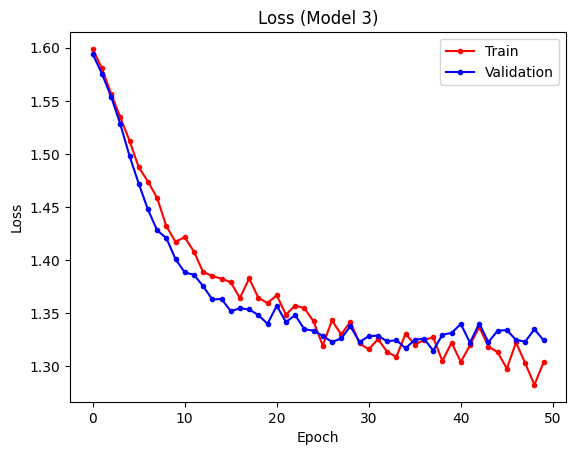

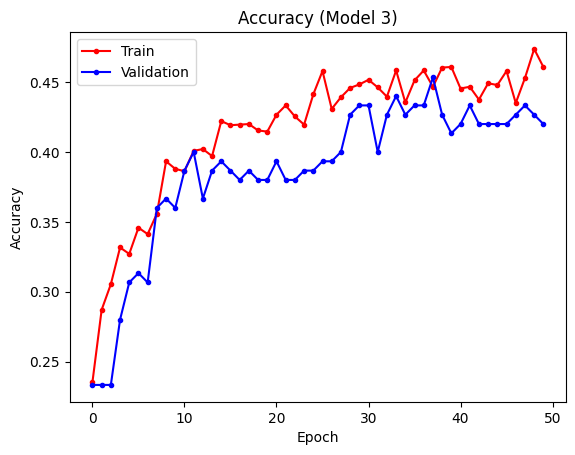

In [127]:
plot_history(history_1_model_3, "Model 3")